# Facebook: Paid vs Unpaid Posts

### Introduction
**Background** 

We are in the digital era, and Facebook is one of the biggest social media platforms known to society. Hence, it is a great platform for different businesses to reach consumers globally. With this idea in mind, we believe it would be beneficial for businesses to know if they should pay for a post to achieve a certain number of post total reach, post engagements, and page likes, or if it is better to follow the organic route. This is significant for designing marketing strategies, especially for small businesses or start-ups with limited funds.

**Question** 

The question of interest is: Can we use the amount of lifetime post total reach and lifetime people who have liked the page and engaged with the post to predict whether a future post is paid or unpaid?

**Dataset** 

The [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip) we will use to answer this question consists of data from 500 of the 790 Facebook posts of a renowned cosmetic brand in 2014. The remaining instances were ommitted due to confidentiality concerns. This data was downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Facebook+metrics). 

Each row in the dataset shows the type of post (paid vs unpaid) as well as post performance metrics, from the number of likes and shares to total impressions. According to the paper from which the dataset is based on, most of the information was exported directly from the company's Facebook page (Moro et al., 2016).

### Methods and Results

##### Step 1
The following packages are loaded using the `library` function to be able to use the functions necessary to perform our data analysis and build our classifier.

In [1]:
# load packages
library(repr)
library(tidyverse)
library(tidymodels)

options(repr.plot.width = 8, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Variable Description** 

The columns in the dataset that we are interested in for our analysis are:

- `Lifetime_Post`: The number of unique users who saw a page post
- `Lifetime_Like_Engage`: The number of unique users who have liked a page and clicked anywhere in a post
- `Paid`: Whether the post is paid (1) or unpaid (0)

We will use `Lifetime_Post` as one of the predictors because it is a measure of how much exposure a post achieves by quantifying the unique users who have seen the post (Moro et al., 2016). In this case, "unique users" mean that an individual who owns multiple Facebook accounts is only considered as one user. We will also use `Lifetime_Like_Engage` as a predictor because it is said to be a stronger measure for user feedback, since this ensures that the user is interested in the post (Moro et al., 2016). Therefore, we will focus on these two predictors only for our classifier to predict the target/response variable (`Paid`).

##### Step 2
After downloading the data from the web and reading it into R, we convert the `Paid` column into a factor with the `as_factor()` function as it is originally a numerical variable and we want to use it as a class/label to classify our observations as paid or unpaid. Moreover, we will need to select the relevant columns for our analysis, `Lifetime_Post`, `Lifetime_Like_Engage`, and `Paid` using the `select()` function.

The dataset is also scaled using the `mutate` function to ensure that each predictor would have equal influence on the classifier. The `filter` function is also used to remove any `NA` values under the `Paid` column, as this is irrelevant to our classifier.

In [2]:
set.seed(3060) # set seed to make analysis reproducible

# load data
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip", temp, mode = "wb")
unzip(temp, "dataset_Facebook.csv")
facebook_unscaled <- read.delim("dataset_Facebook.csv", sep = ";") %>% 
    mutate(Paid = as_factor(Paid)) %>% 
    select(
        Paid,
        Lifetime_Post = Lifetime.Post.Total.Reach,
        Lifetime_Like_Engage = Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post
    )

# scale data
facebook <- facebook_unscaled %>%
    filter(!is.na(Paid)) %>% # remove rows where Paid is NA
    mutate(
        Lifetime_Post = scale(Lifetime_Post, center = TRUE),
        Lifetime_Like_Engage = scale(Lifetime_Like_Engage, center = TRUE)
    )
facebook

Paid,Lifetime_Post,Lifetime_Like_Engage
<fct>,"<dbl[,1]>","<dbl[,1]>"
0,-0.4908219,-0.8016572
0,-0.1521492,0.8111968
0,-0.5057168,-0.7804569
⋮,⋮,⋮
0,-0.4588352,-0.5048529
0,-0.4457417,-0.4037438
0,-0.4291332,-0.3923282


**Table 1: Scaled Facebook Dataset**

##### Step 3
The dataset is then randomly shuffled and split into a training and testing set, wherein the training set consists of 75% of the dataset whereas the testing set consists of the remaining 25%. We chose 75% as this was deemed to be a good starting point for our classifier to be built with. The training set is used to build and tune the classifier. The testing set is used to estimate the accuracy of the training set classifier in predicting observations in the testing set. This is where we also tell the classifier that the class we want to predict is the Paid column. We also visualize a plot using the training data with Lifetime Post Total Reach on the x-axis and Lifetime People who have liked your Page and engaged with your post on the y-axis, with Paid/Unpaid being distinguished by colors. Although the two variables had a fairly positive relationship, it was impossible to differentiate paid/unpaid purely based on the graph.

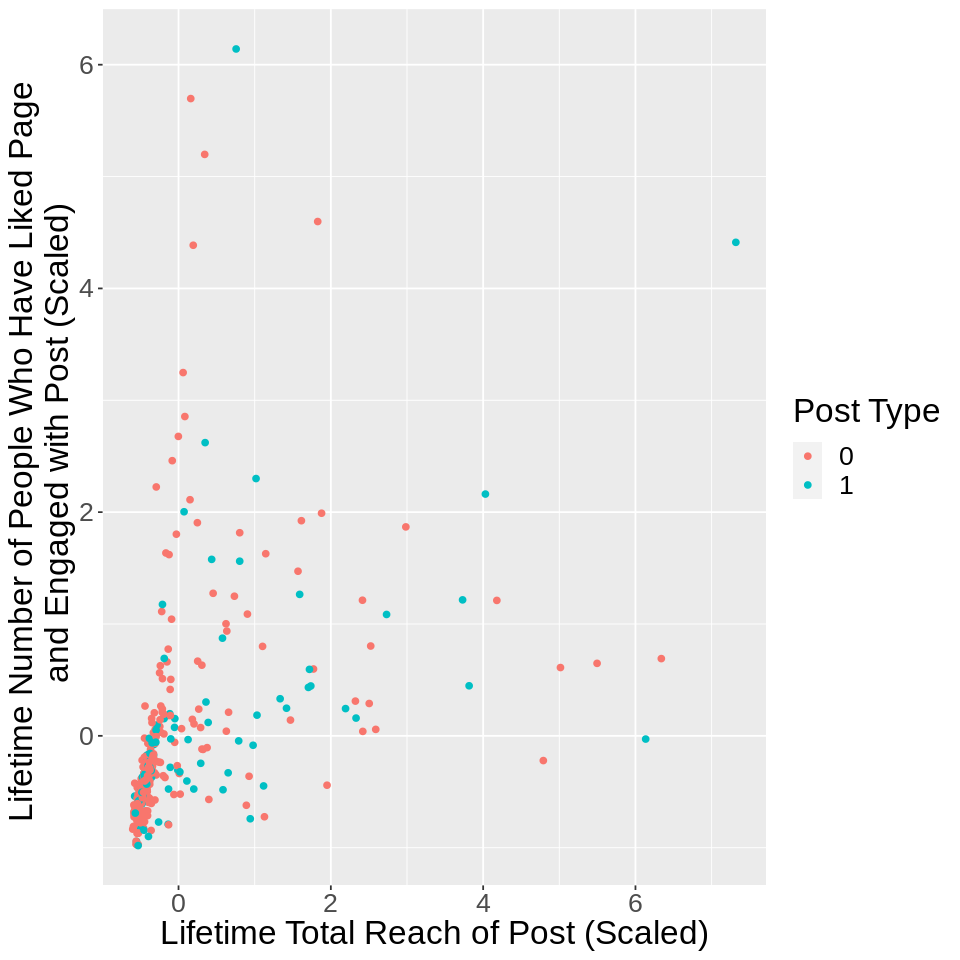

In [3]:
#splitting the data into a training and testing dataset
facebook_split <- initial_split(facebook, prop = 0.75, strata = Paid) 
facebook_train <- training(facebook_split)   
facebook_test <- testing(facebook_split)

facebook_plot <- ggplot(facebook_train, aes(x = Lifetime_Post, y = Lifetime_Like_Engage, colour = Paid)) +
    geom_point() +
    labs(x = "Lifetime Total Reach of Post (Scaled)", y = "Lifetime Number of People Who Have Liked Page \n and Engaged with Post (Scaled)",
              color = "Post Type") +
    theme(text = element_text(size = 20))
facebook_plot

**Graph 2: Lifetime Post Total Reach vs Lifetime People who have Liked the page and Engaged with the post**

##### Step 4
Using the training dataset, we build and tune the classifier that we will use to predict observations. It is important that we scale and center the chosen predictors, using the setp_scale() and step_center() functions, to ensure that no variable would have a higher influence in the prediction due to their larger scale. We include in our recipe that the predictors we want are Lifetime_Post and Liketime_Like_Engage, therefore using all_predictors() would mean that these are the variables we would like to scale and center. 

Furthermore, we do 5-fold cross-validation, using the vfold_cv() function, to build the model to establish the number of neighbours that would be best to achieve the highest estimated accuracy. In cross-validation, we have to consider size of the data as well as the speed of both the algorithm and the computer. Thus, 5 is typically a good number to proceed with. Similarly, we input in the grid argument that we want to find a K between 1 and 20, taking into account the amount of computational power necessary. We then add the recipe and model into our workflow wherein we tell the classifier we want to try tuning it with 10 different Ks through the grid argument.

In [4]:
#building and tuning the classifier
facebook_recipe <- recipe(Paid ~ Lifetime_Post + Lifetime_Like_Engage, data = facebook_train) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())

facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = Paid)

knn_tune<- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
      set_engine('kknn') %>%
      set_mode('classification')

k_vals <- tibble(neighbors = seq(1,20))
knn_results <- workflow() %>%
      add_recipe(facebook_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = facebook_vfold, grid = k_vals) %>%
      collect_metrics()

##### Step 5
Because we only care about the mean of the accuracy, we use the filter() function to filter out these specific rows under the .metric column. We then plot out the graph wherein the x-axis consists of the neighbors column and the y-axis contains the respective means of these neighbours. The graph allows us to visualize and choose the k with the highest accuracy to use for our testing dataset.

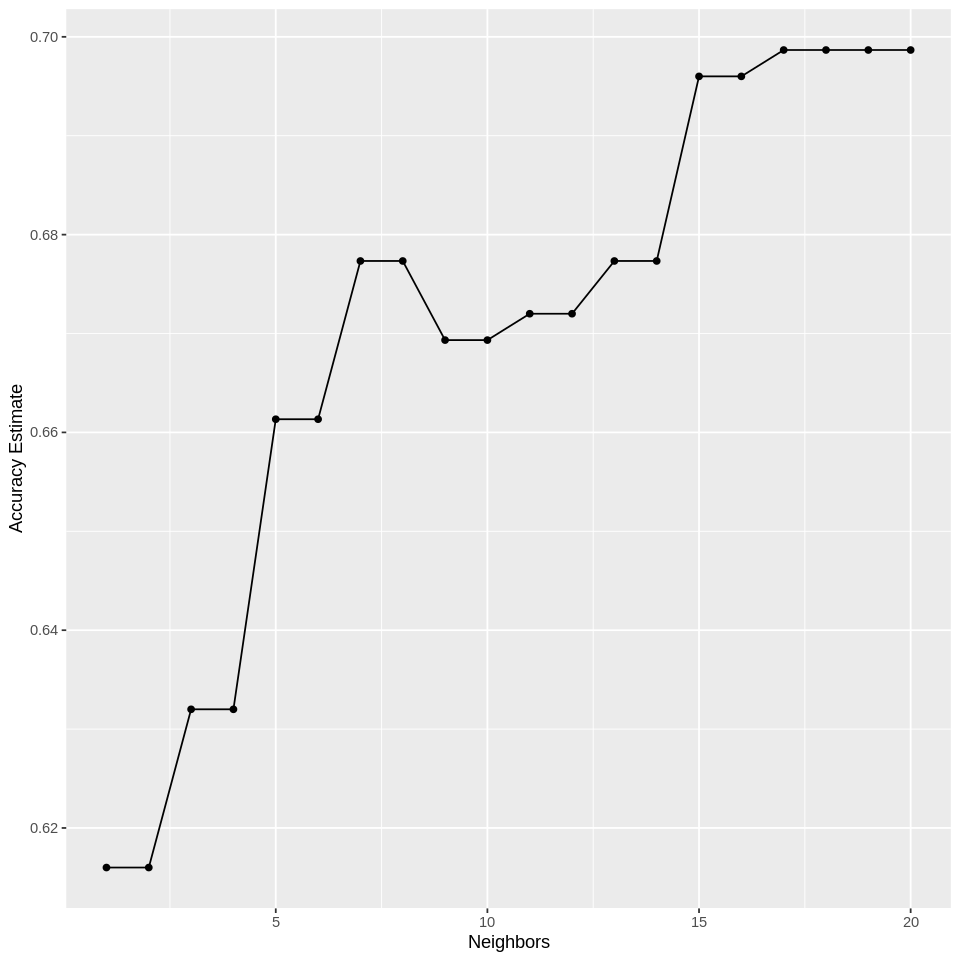

In [5]:
#choosing the correct number of neighbours
accuracies <- knn_results %>% 
      filter(.metric == 'accuracy')

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_versus_k

**Graph 2: K value vs Accuracy Graph**

##### Step 6
Through the graph, we see that the number of neighbours with the highest accuracy estimate of just below 70% is 17, 18, 19, and 20. However, we cannot be absolutely sure based on visualization, so we use the filter() function to filter out the row with the highest mean and pull(neighbors) function to pull the value of the k with the highest accuracy, which indeed turned out to be those two values. Unfortunately, we can only pick one value to use to test our accuracy hence we used 14.

In [6]:
#building classifier with chosen number of neighbours
k_max <- accuracies %>%
    filter(mean == max(mean)) %>%
    pull(neighbors)
k_max

knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 20) %>%
      set_engine('kknn') %>%
      set_mode('classification')

[1] 17 18 19 20

##### Step 7
Next, we perform the workflow analysis again. We run cross-validation on each train/validation split to determine how accurate the classifier's validation was across the folds. The collect_metrics functions shows a table with the mean accuracy and standard error (uncertainty of mean value). 

In [7]:
facebook_fit <- workflow() %>%
      add_recipe(facebook_recipe) %>%
      add_model(knn_spec) %>%
      fit_resamples(resamples = facebook_vfold)

facebook_metrics<-collect_metrics(facebook_fit)
facebook_metrics

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.6986667,5,0.00800000
roc_auc,binary,0.5677249,5,0.02453204


**Table 2: Classifier's Prediction Accuracy on the Training Dataset**

##### Step 8
Now that we have created our K-nearest neighbor classifier object with max k accuracy (k=20), we need to test our tuned classifier on the testing data. First, we train the classifier with the training data set using the workflow function. This bundles together the pre-processing, modeling, and post-processing requests. Then we use the classifier to predict the Paid value using the two predictors in the testing dataset. Lastly, we compare the classifier predictions to the true values from the Paid column in the testing dataset to measure the accuracy. We displayed this using a metrics table and also a confusion matrix for better visualization.

In [8]:
#estimating the accuracy of the classifier on the testing data
facebook_fit_test <- workflow() %>%
    add_recipe(facebook_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = facebook_train)

facebook_test_prediction <- predict(facebook_fit_test, facebook_test) %>%
    bind_cols(facebook_test)

facebook_metrics <- facebook_test_prediction %>%
    metrics(truth = Paid, estimate = .pred_class)
facebook_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7338710
kap,binary,0.1330508


**Table 3: Classifier's Prediction Accuracy on the Testing Dataset**

In [9]:
confusion <- facebook_test_prediction %>%
    conf_mat(truth = Paid, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 86 29
         1  4  5

**Table 4: Confusion Matrix**

### Discussion

**Summary:**
Overall, it was found that lifetime post reach and lifetime likes and engagement are moderately accurate predictors of whether a Facebook post is paid or not. Although the classifier had a prediction accuracy of 73% on the testing dataset (Table 3), the predicted trend is not reliably seen in our results. We see in Figure 2 that there is a positive relationship between the two predictor variables, however, it is still difficult to determine the type of post visually using only the graph. It can also be noted that in Table 4, among the 91 correct predictions, only 5 of those posts were correctly predicted as paid posts. This means that our classifier's accuracy is fairly skewed since the ratio of correct predictions is 86:5 for unpaid to paid posts; therefore it appears that our classifier is unreliable in predicting paid posts. Tracing back, perhaps the $k$ value for the classifier also suffers from the same problem. The $k$ value of 14 had the highest accuracy, but that could also be skewed by identifying a higher number of unpaid posts correctly, which could be a question for further analysis.

33 predictions are incorrect. It can also be noted that we predicted 29 unpaid posts when they were actually paid posts, and only 5 of these paid posts were correctly predicted. This means that the classifier's accuracy is fairly skewed since the ratio of correct predictions is 86:5 for unpaid to paid posts 

**Expected Results:** Contrary to our hypothesis, a higher lifetime post reach and higher lifetime likes and engagement did not reliably correlate to a paid post. This finding seemingly replicates the findings of another [study](https://www.sciencedirect.com/science/article/pii/S0148296316000813), where it was found that a paid post only boosted its reachability by 7% (Moro et al., 2016). Interestingly, lifetime post reach appearss to be a slightly more accurate predictor, compared to the page/post engagement predictor. 

**Impact of Findings:** Our classifier's accuracy was about 70%, this means that about 30% of the time our classifier makes a mistake. Based on the findings, we think that there is room for improvement before we can make predictions regarding whether a post is paid or not. For instance, we might want to include more data, specifically paid post examples as this is where our classifier mispredicted the most (Table 4).

Perhaps we could also improve the classifier accuracy by including other predictors as there were paid posts with low reach, low engagement, and low page likes; hence, this suggests that there may be other factors involved in determining the type of post. A [study](https://www.tandfonline.com/doi/abs/10.1080/10641734.2018.1503113?journalCode=ujci20) found that many different factors may affect post likes and engagement (Quesenberry & Coolsen, 2018). For example, post content and even when the post was created have significant effects on how many likes/engagements the post achieves. Thus, these other factors should be examined in future studies to determine how they may act as moderating factors. 

In terms of application, companies can use this information, combined with actual purchasing data, to streamline their advertising strategies. Specifically, paying for a specific type of post in a specific month may help increase post reach, which would increase potential consumer exposure, which may in turn increase purchases.

**Future Questions:**
Some future questions that this could lead to are: Why do some paid posts have low total reach and low engagement/page likes? Are there other factors companies should consider when paying for posts? Does having a higher post reach and engagement necessarily translate to having a better value from social media posts?

### References

Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research, 69(9), 3341-3351. doi:10.1016/j.jbusres.2016.02.010


Quesenberry, K. A., & Coolsen, M. K. (2018). What Makes Facebook Brand Posts Engaging? A Content Analysis of Facebook Brand Post Text That Increases Shares, Likes, and Comments to Influence Organic Viral Reach. Journal of Current Issues & Research in Advertising, 40(3), 229-244. doi:10.1080/10641734.2018.1503113

